In [54]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pyfits
import plotc
import read_params
np.set_printoptions(precision=3)
import scipy.integrate, scipy.interpolate, scipy.fftpack, scipy.special
import dbyd2
import matplotlib.ticker
%load_ext Cython

def fitsread(f): return np.squeeze(pyfits.getdata(f)).byteswap().newbyteorder()

Lx=read_params.get_xlength()
nx=read_params.get_nx()
x=np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
z=np.loadtxt(read_params.get_solarmodel(),usecols=[0])
Rsun = 6.95989467700E2
z=(z-1)*Rsun

c,rho = np.loadtxt(read_params.get_solarmodel(),usecols=[1,2],unpack=True)
c.shape += (1,)
rho.shape += (1,)
c = c/100 # Convert to m/s

def ind_x(x): return int((x/Lx+1/2)*nx)
def ind_z(z_coord): return abs(z-z_coord).argmin()

z_surf=ind_z(0)

dbyd2_z = np.zeros((1,)+z.shape,order='F')
dbyd2.dbyd2(dbyd2_z,np.asfortranarray(np.atleast_2d(z)),1)

def ddz(arr):
    arr = np.asfortranarray(arr).T
    numerator = np.zeros(arr.shape,order='F')
    dbyd2.dbyd2(numerator,arr,1)
    return (numerator/dbyd2_z).T

def ddz_2p(arr):
    arr = np.squeeze(arr)
    dz = np.gradient(z)
    if len(arr.shape)==1: 
        darr = np.gradient(arr)
    else: 
        darr = np.gradient(arr)[0]
        dz.shape+=(1,)
    
    return darr/dz

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


### Density and sound-speed near surface

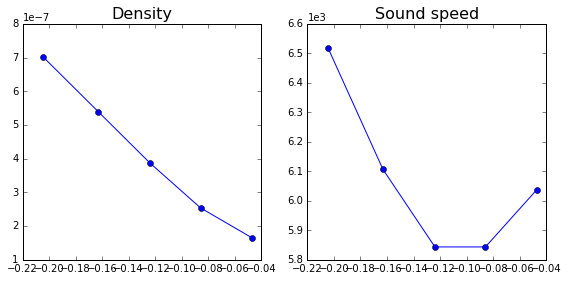

In [40]:
z_left = -0.2; z_right = 0.0

plt.subplot(121)
plt.plot(z[ind_z(z_left):ind_z(z_right)],rho[ind_z(z_left):ind_z(z_right),0],'-o')
plt.ticklabel_format(style="sci",scilimits=(0,0),axis="y")
plt.title("Density",fontsize=16)

plt.subplot(122)
plt.plot(z[ind_z(z_left):ind_z(z_right)],c[ind_z(z_left):ind_z(z_right),0],'-o')
plt.ticklabel_format(style="sci",scilimits=(0,0),axis="y")
plt.title("Sound speed",fontsize=16)

plt.gcf().set_size_inches(8,4)
plt.tight_layout()

### Load the non-smoothed velocity fields

In [3]:
true_vx_sparc = fitsread('true_vx.fits')
true_vz_sparc = fitsread('true_vz.fits')
true_psi_sparc = fitsread('true_psi.fits')

## Velocity and vector potential

The vector potential is defined as 

$$ \psi = \frac{v_{0}}{c\left(z\right)}\frac{\mathrm{sign}\left(x\right)}{k}\,J_{1}\left(k\left|x\right|\right)\exp\left(-\frac{\left(z-z_{0}\right)^{2}}{2\sigma_{z}^{2}}-\frac{\left|x\right|}{R}\right)+\psi_{0}^{\mathrm{ref}} $$

Velocity components are defined as 


$$ \begin{eqnarray*}
\mathbf{v} & = & \frac{1}{\rho}\nabla\left(\rho c\psi\right)\\
v_{x} & = & -\frac{1}{\rho}\partial_{z}\left(\rho c\psi\right)\\
v_{z} & = & \frac{1}{\rho}\partial_{x}\left(\rho c\psi\right)\\
 & = & \partial_{x}\psi
\end{eqnarray*} $$

Evaluating the derivatives analytically we obtain 

$$ \begin{eqnarray*}
v_{x} & = & v_{0}\left[\frac{\mathrm{sign}\left(x\right)}{k}\,J_{1}\left(k\left|x\right|\right)\exp\left(-\frac{\left|x\right|}{R}\right)\right]\left(\frac{\left(z-z_{0}\right)}{\sigma_{z}^{2}}-\frac{\rho^{\prime}\left(z\right)}{\rho\left(z\right)}\right)\exp\left(-\frac{\left(z-z_{0}\right)^{2}}{2\sigma_{z}^{2}}\right),\\
v_{z} & = & v_{0}\left[\left(\frac{1}{2}\left(J_{0}\left(k\left|x\right|\right)-J_{2}\left(k\left|x\right|\right)\right)-\frac{1}{kR}J_{1}\left(k\left|x\right|\right)\right)\exp\left(-\frac{\left|x\right|}{R}\right)\right]\exp\left(-\frac{\left(z-z_{0}\right)^{2}}{2\sigma_{z}^{2}}\right).
\end{eqnarray*}$$

#### Define parameters

$ v_{0}=240\,\mathrm{ms^{-1}}
 , k=2\pi/30\,\mathrm{rad\,Mm^{-1}}
 , R=15\,\mathrm{Mm}
 , z_{0}=-2.3\,\mathrm{Mm}
  \;\mathrm{and}\; \sigma_{z}=0.912\,\mathrm{Mm} $ 

In [79]:
v0 = 240; k=2*np.pi/30; R=15; z0=-2.3; sigmaz = 0.912

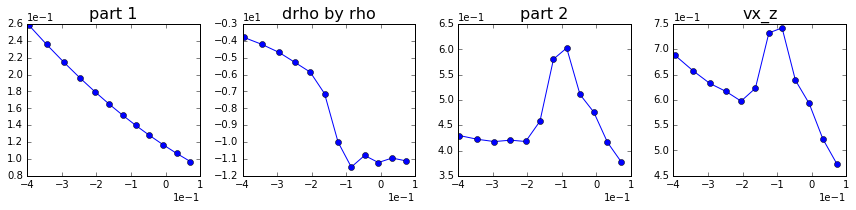

In [85]:
drho_by_rho = ddz(rho).flatten()/rho.flatten()

vx_z = ((z-z0)/sigmaz**2 - drho_by_rho)*np.exp(-(z-z0)**2/(2*sigmaz**2))
vx_z_1 = (z-z0)/sigmaz**2*np.exp(-(z-z0)**2/(2*sigmaz**2))
vx_z_2 = -drho_by_rho*np.exp(-(z-z0)**2/(2*sigmaz**2))

z_left = -0.4; z_right = 0.1

def surface(arr): return arr[ind_z(z_left):ind_z(z_right)]

plt.subplot(141)
plt.plot(surface(z),surface(vx_z_1),'-o')
plt.title("part 1",fontsize=16)
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.subplot(142)
plt.plot(surface(z),surface(drho_by_rho),'-o')
plt.title("drho by rho",fontsize=16)
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.subplot(143)
plt.plot(surface(z),surface(vx_z_2),'-o')
plt.title("part 2",fontsize=16)
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.subplot(144)
plt.plot(surface(z),surface(vx_z),'-o');
plt.title("vx_z",fontsize=16)
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.gcf().set_size_inches(12,3)
plt.tight_layout()

What's up with $d\rho/\rho$?

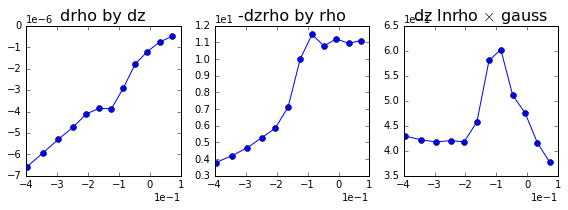

In [89]:
plt.subplot(131)
drho = ddz(rho).flatten()
plt.plot(surface(z),surface(drho),'-o');
plt.ticklabel_format(style="sci",scilimits=(0,0))
plt.title("drho by dz",fontsize=16)

plt.subplot(132)
drho_by_rho = -ddz(rho).flatten()/rho.flatten()
plt.plot(surface(z),surface(drho_by_rho),'-o');
plt.ticklabel_format(style="sci",scilimits=(0,0))
plt.title("-dzrho by rho",fontsize=16)

plt.subplot(133)
drho_by_rho = -ddz(rho).flatten()/rho.flatten()
drho_by_rho_gaussian = drho_by_rho*np.exp(-(z-z0)**2/(2*sigmaz**2))
plt.plot(surface(z),surface(drho_by_rho_gaussian),'-o');
plt.ticklabel_format(style="sci",scilimits=(0,0))
plt.title(r"dz lnrho $\times$ gauss",fontsize=16)

plt.gcf().set_size_inches(8,3)
plt.tight_layout()

Let us smooth dz rho

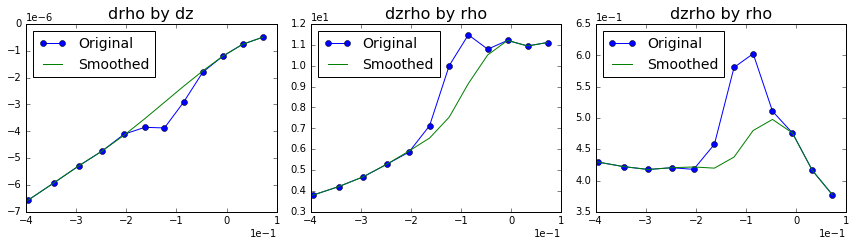

In [114]:
z_left_1 = -0.8; z_right_1 = -0.2; z_left_2 = -0; z_right_2 = z[-1]
def lr(arr):
    arr_left = arr[ind_z(z_left_1):ind_z(z_right_1)]
    arr_right = arr[ind_z(z_left_2):ind_z(z_right_2)]
    return np.concatenate((arr_left,arr_right))

s = scipy.interpolate.InterpolatedUnivariateSpline(lr(z),lr(drho))

drho_smoothed_surf = s(surface(z))
drho_smoothed = np.concatenate((drho[:ind_z(z_left_1)],s(z[ind_z(z_left_1):])))

plt.subplot(131)
plt.plot(surface(z),surface(drho),'-o',label="Original");
plt.plot(surface(z),drho_smoothed_surf,'-',label="Smoothed");
plt.title("drho by dz",fontsize=16)
plt.legend(loc="best",fontsize=14);
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.subplot(132)
plt.plot(surface(z),surface(drho_by_rho),'-o',label="Original");
plt.plot(surface(z),-drho_smoothed_surf/surface(rho.flatten()),'-',label="Smoothed");
plt.title("dzrho by rho",fontsize=16)
plt.legend(loc="best",fontsize=14);
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.subplot(133)
plt.plot(surface(z),surface(drho_by_rho_gaussian),'-o',label="Original");
plt.plot(surface(z),-drho_smoothed_surf/surface(rho.flatten())*surface(np.exp(-(z-z0)**2/(2*sigmaz**2))),
         '-',label="Smoothed");
plt.title("dzrho by rho",fontsize=16)
plt.legend(loc="best",fontsize=14);
plt.ticklabel_format(style="sci",scilimits=(0,0))

plt.gcf().set_size_inches(12,3.5)
plt.tight_layout()

In [117]:
solar_model=np.loadtxt(read_params.get_solarmodel())
# Columns are 0:z, 1:c; 2:rho, 3:p, 4:g; 5:gamma
# Let us add an extra column at position 3
solar_model_with_dzrho = np.insert(solar_model,3,drho_smoothed,axis=1)
np.savetxt(read_params.get_solarmodel()+"_smoothed_dzrho",solar_model_with_dzrho)